In [2]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
%cd /content/gdrive/MyDrive/style-transfer-research/Rolling
!ls

/content/gdrive/MyDrive/style-transfer-research/Rolling
18.40.Style_transfer_rolling_2output.ipynb  rolling_2outputs_random
18.9.Style_transfer_rolling.ipynb	    rotation
19.2.Style_transfer_rolling_2output.ipynb   Sandwich-Batch-Normalization
rolling_2outputs			    Style_transfer_rotation.ipynb


In [4]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import os
import copy

In [5]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [6]:
# content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
# style_path   = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [7]:
content_path = "/content/gdrive/MyDrive/style-transfer-research/SAFIN/input/content/golden_gate.jpg"
style_path = "/content/gdrive/MyDrive/style-transfer-research/SAFIN/input/style/styles-97.jpg"
output_name = content_path.split('/')[-1].replace('.jpg','') + "_" + style_path.split('/')[-1].replace('.jpg','') + '_1.0'
output_dir = f'rotation/{output_name}'

In [8]:
def load_img(path_to_img):
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  img = tf.image.resize(img, (422, 512))
  img = img[tf.newaxis, :]
  return img

In [9]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

(1, 422, 512, 3)
(1, 422, 512, 3)


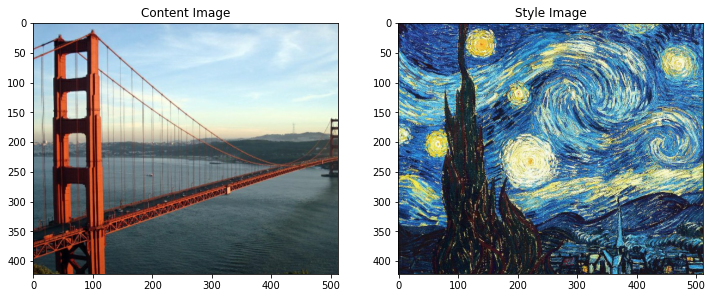

In [10]:
content_image = load_img(content_path)
style_image = load_img(style_path)

print(content_image.shape)
print(style_image.shape)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [11]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
content_layers = ['block5_conv2']
style_layers   = ['block1_conv1',
                  'block2_conv1',
                  'block3_conv1', 
                  'block4_conv1', 
                  'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers   = len(style_layers)

80150528/80134624 [==============================] - 1s 0us/step


In [12]:
def vgg_layers(layer_names):
  """ Creates a vgg model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on imagenet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model   = tf.keras.Model([vgg.input], outputs)
  return model

In [13]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [14]:
def rotation_tensor(inputs, angles = None):
    """Rotate tensor in 90, 180, 270 angles"""
    final = copy.deepcopy(inputs)
    if angles == 90:
        for key, input in enumerate(inputs):
            input = input.numpy()
            input_shape = input.shape
            x90 = input.transpose((3, 2, 1 ,0)).reshape(input_shape)
            x90 = tf.convert_to_tensor(x90)
            final[key] = x90
        return final

    if angles == 180:
        for key, input in enumerate(inputs):
            input = input.numpy()
            input_shape = input.shape
            x180 = np.flip(input, 2)
            x180 = tf.convert_to_tensor(x180)
            final[key] = x180
        return final

    if angles == 270:
        for key, input in enumerate(inputs):
            input = input.numpy()
            input_shape = input.shape
            x90 = input.transpose((3, 2, 1 ,0)).reshape(input_shape)
            x270 = np.flip(x90, 3).reshape(input_shape)
            x270 = tf.convert_to_tensor(x270)
            final[key] = x90
        return final

    if angles not in [90, 180, 270]:
        raise ValueError('Invalid value')

In [15]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [16]:
class StyleContentModel_style(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers, rotation_weight):
    super(StyleContentModel_style, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False
    self.rotation_weight = rotation_weight

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])
    
    # Rotation
    style_outputs_90 = rotation_tensor(style_outputs, 90)
    style_outputs_180 = rotation_tensor(style_outputs, 180)
    style_outputs_270 = rotation_tensor(style_outputs, 270)
    
    style_outputs_1 = [gram_matrix(style_output)
                     for style_output in style_outputs]
    
    # Fusion
    style_outputs_2 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_90)]

    style_outputs_3 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_180)]

    style_outputs_4 = [(1 - self.rotation_weight) * gram_matrix(style_output1) + self.rotation_weight * gram_matrix(style_output2)
                     for style_output1, style_output2 in zip(style_outputs, style_outputs_270)]

    # Save feature
    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict_1 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_1)}

    style_dict_2 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_2)}

    style_dict_3 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_3)}

    style_dict_4 = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs_4)}
    
    return {'content':content_dict, 'style_1':style_dict_1, 'style_2':style_dict_2, 'style_3':style_dict_3, 'style_4':style_dict_4}

In [17]:
extractor_style = StyleContentModel_style(style_layers, content_layers, rotation_weight = 1.0)
extractor       = StyleContentModel(style_layers, content_layers)

In [18]:
style_targets_1 = extractor_style(style_image)['style_1']
style_targets_2 = extractor_style(style_image)['style_2']
style_targets_3 = extractor_style(style_image)['style_3']
style_targets_4 = extractor_style(style_image)['style_4']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [19]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight=1e-2
content_weight=1e4

In [20]:
def style_content_loss_1(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_1[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_2(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_2[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_3(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_3[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

def style_content_loss_4(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets_4[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [21]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_weight=30

In [22]:
@tf.function()
def train_step(image_1, image_2, image_3, image_4):
  with tf.GradientTape() as tape_1, tf.GradientTape() as tape_2, tf.GradientTape() as tape_3, tf.GradientTape() as tape_4:
    outputs_1 = extractor(image_1)
    outputs_2 = extractor(image_2)
    outputs_3 = extractor(image_3)
    outputs_4 = extractor(image_4)

    loss_1 = style_content_loss_1(outputs_1)
    loss_2 = style_content_loss_2(outputs_2)
    loss_3 = style_content_loss_3(outputs_3)
    loss_4 = style_content_loss_4(outputs_4)

    loss_1 += total_variation_weight*tf.image.total_variation(image_1)
    loss_2 += total_variation_weight*tf.image.total_variation(image_2)
    loss_3 += total_variation_weight*tf.image.total_variation(image_3)
    loss_4 += total_variation_weight*tf.image.total_variation(image_4)

  grad_1 = tape_1.gradient(loss_1, image_1)
  grad_2 = tape_2.gradient(loss_2, image_2)
  grad_3 = tape_3.gradient(loss_3, image_3)
  grad_4 = tape_4.gradient(loss_4, image_4)

  opt.apply_gradients([(grad_1, image_1)])
  opt.apply_gradients([(grad_2, image_2)])
  opt.apply_gradients([(grad_3, image_3)])
  opt.apply_gradients([(grad_4, image_4)])

  image_1.assign(clip_0_1(image_1))
  image_2.assign(clip_0_1(image_2))
  image_3.assign(clip_0_1(image_3))
  image_4.assign(clip_0_1(image_4))

In [23]:
image_1 = tf.Variable(content_image)
image_2 = tf.Variable(content_image)
image_3 = tf.Variable(content_image)
image_4 = tf.Variable(content_image)

import time
start = time.time()

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

epochs = 30
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image_1, image_2,image_3, image_4)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image_1))
  display.display(tensor_to_image(image_2))
  display.display(tensor_to_image(image_3))
  display.display(tensor_to_image(image_4))
  print("Train step: {}".format(step))

  fname_1 = f'{output_dir}/at_{n+1}_output1.png' 
  mpl.image.imsave(fname_1, image_1[0].numpy())

  fname_2 = f'{output_dir}/at_{n+1}_output2.png' 
  mpl.image.imsave(fname_2, image_2[0].numpy())

  fname_3 = f'{output_dir}/at_{n+1}_output3.png' 
  mpl.image.imsave(fname_3, image_3[0].numpy())

  fname_4 = f'{output_dir}/at_{n+1}_output4.png' 
  mpl.image.imsave(fname_4, image_4[0].numpy())

end = time.time()
print("Total time: {:.1f}".format(end-start))

Output hidden; open in https://colab.research.google.com to view.